In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import jax.numpy as jnp
import jax
from functools import partial
import numpy as np
import flax
import flax.linen as nn

# 1D Ising Chain with transversal field

This model consists of $N$ fixed particles with $1/2$-spin numbers, and its interactions are driven by this spin component only, with a constant interaction parameter $J$, and only between firsts neighbors. Also, a transversal magnetic field of magnitude $g$ is applied in an orthogonal direction of the interactive spins. For convenience, suppose that the particles interact along the $z$-direction, and that the transversal magnetic field points towards the $x$-direction.

### Hamiltonian and Hilbert space

The Hamiltonian of such model is given by,

$$\hat{H}_I = -J \sum_{\langle i,j\rangle} \hat{\sigma}_i^z \hat{\sigma}_j^z - g\sum_{i=1}^N \hat{\sigma}_i^x.$$

First, we want to define the variational model. In this case, suppose we have a transverse field Ising model whose Hilbert space is the basis of the operator $\hat{\sigma}^z = \sum_{i=1}^N \sigma_i^z$ given by $\mathcal{H} = Span\{\ket{\sigma}=\ket{\sigma^z_0, \sigma^z_1,..., \sigma^z_{N-1}}\}$, where $\sigma^z_i$ is the value of the spin in the site $i$ in the direction of $z$. In this case, we want to build a variational ansatz of the form:

$$\ket{\Psi_\alpha} = \sum_{\sigma\in\mathcal{H}} \psi_\alpha (\sigma)\ket{\sigma}.$$

We will first initialize the parameters of the RBM that will serve us as the variational probability $\psi_\alpha (\sigma)$.

### First variational wave-function: Mean Field ansatz

As first approximation, we propose a mean-field ansatz of the form,

$$\ket{\Psi_{\lambda}} = \sum_{i=1}^{N_s}\left[\prod_{j=1}^N\Phi(\lambda; \sigma_j^z)\right]\ket{\sigma_i},$$

where $\ket{\sigma_i}$ is the $i$-th configuration in the Hilbert space basis $\mathcal{H}$, whose has $N_s$ configuration elements, and $\Phi(\lambda; \sigma^z) = \sqrt{P(\lambda; \sigma^z)}\exp(i\phi(\lambda; \sigma^z))$ is the probability amplitude. We choose the complex phase zero, $\phi=0$ and the probability function as the sigmoid, $P(\sigma^z; \lambda) = 1/(1+\exp(-\lambda\sigma^z))$.

### JAX Implementation

In the follow code cell, we implement a lazy brute-force version of this mean-field ansatz in JAX. Since we mostly work with the natural log of the probabilities, we implement this class mean_field_ansatz in order to return the log probability, given by,

$$\log(\braket{\sigma\mid\Psi_{MF}}) = \frac{1}{2}\sum_{j=1}^N \log(P(\sigma_i^z; \lambda)).$$

In [40]:
class mean_field_ansatz:
    
    def __init__(self, param = None):
        key = jax.random.PRNGKey(1)

        if param==None:
            key, subkey = jax.random.split(key, 2)
            param = jax.random.uniform(subkey, shape = (1,))
        
        self.param = param
    
    def __call__(self, x):
        
        prob = jnp.log(1 / (1 + jnp.exp(- self.param * x)))
        
        return 0.5 * jnp.sum(prob, axis = -1)
    
    def sigmoid(self, x_):
        return 1 / (1 + jnp.exp(- self.param * x_))

In [46]:
MF = mean_field_ansatz(jnp.array([1.]))

In [47]:
xd = jnp.array([2., 3., 5.])

In [48]:
MF(xd)

Array(-0.09111537, dtype=float32)

In [49]:
0.5*jnp.sum(jnp.log(1/(1+jnp.exp(-1.*xd))))

Array(-0.09111537, dtype=float32)

In [30]:
1/(1+jnp.exp(-2*3))

Array(0.9975274, dtype=float32, weak_type=True)

In [42]:
MF = mean_field_ansatz(jnp.array([1.]))

In [43]:
MF(xd)

Array(-0.09111537, dtype=float32)

In [67]:
def init_rbm_params(n_sites, alpha=1, stdv=0.1):
    '''
    Function: init_rbm_params
    Input: 
        n_sites:
            Number of sites in the Ising chain that serve as number of neurons
            in the input layer of the RBM.
        alpha:   
            Proportion M/N between the number of neurons in the output layer and 
            the input layer.
        stdv:    
            Standard deviation of the normal distribution
    Output:
        params:
            A dictionary containing the weights, the bias for the visible neurons and
            the biases for the hidden neurons, in that order.
            
    '''
    a = jnp.asarray(np.random.normal(size = (n_sites,),                    scale = stdv))
    b = jnp.asarray(np.random.normal(size = (int(alpha*n_sites),),         scale = stdv))
    W = jnp.asarray(np.random.normal(size = (int(alpha*n_sites), n_sites), scale = stdv))

    params = dict(
            weights_rbm = W, 
            bias_v = a, 
            bias_h = b
        )
    

    return params

In [68]:
def prob_rbm(params, x):
    """ Compute the forward pass for each example individually """
    
    exponent = jnp.dot(params["bias_v"], x) 
    c = params["bias_h"] + jnp.dot(params["weights_rbm"], x)
    prod = jnp.prod(2*jnp.cosh(c))
    return jnp.exp(exponent)*prod

In [74]:
@jax.jit
def wf_g(params_g, v_):
    return prob_rbm(params_g, v_)

wf_g_batched = jax.vmap(wf_g, in_axes = (None, 0))

@jax.jit
def wf_g_squared(params_g, v_):
    return prob_rbm(params_g, v_)**2

wf_g_squared_batched = jax.vmap(wf_g_squared, in_axes = (None, 0))

@partial(jax.vmap, in_axes = (None, 0), out_axes = 0)
@jax.jit
def wf_squared_g(params_g, v_):
    return wf_g(params_g, v_)**2

@jax.jit
def log_wf_g(params_g, v_):
    return jnp.log(wf_g(params_g, v_))

@jax.jit
def log_pdf_g(params, v_):
    return jnp.log((wf_g(params, v_))**2)

log_grads_g = jax.grad(log_wf_g)

def norm_g(params_g, states):
    return jnp.sum(wf_g_squared_batched(params_g, states))

In [71]:
def hilbert_space(n_sites):
    seed = np.ones(n_sites)
    states = [seed]
    j=n_sites-1
    while j!=-1:
        n_states = len(states)
        for i in range(n_states):
            state_copy = np.copy(states[i])
            state_copy[j]*=-1
            states.append(state_copy)
        j -= 1
    return jnp.array(states)

In [72]:
@partial(jax.vmap, in_axes = (None, None, 0, None), out_axes = 0)
def en_loc_g(params, prop, pos, n_sites):
    J, g = prop
    func = partial(wf_g, params)
    local = jnp.sum(pos*jnp.roll(pos, 1))*(-J) + \
                jnp.sum(jnp.array([func(pos.at[i].multiply(-1)) for i in range(n_sites)]))*(-g)/func(pos)
    return local

In [73]:
@jax.jit
@partial(jax.vmap, in_axes = (None, 0, 0, None, None), out_axes = 0)
def grad_en_g(params_g, sample, loc_en, sv_en, normg):
    grads = jax.grad(log_wf_g)(params_g, sample)
    prob = wf_g_squared(params_g, sample)/normg
    return jax.tree_map(lambda grad: 2*jnp.real(((loc_en - sv_en))*grad*prob), grads)

In [75]:
def sgd_g(rng_key, params, lr, prop, n_sites, samples_array):
    normg = norm_g(params, samples_array)
    loc_en = en_loc_g(params, prop, samples_array, n_sites)
    sv_en = jnp.sum(loc_en*wf_g_squared_batched(params, samples_array))/normg
    grads = grad_en_g(params, samples_array, loc_en, sv_en, normg)
    grads = jax.tree_util.tree_map(lambda g: jnp.sum(g, axis=0), grads)
    new_params = jax.tree_util.tree_map(lambda p, g: p - lr * g, params, grads)
    return rng_key, sv_en, new_params

In [76]:
from tqdm import tqdm

n_iters =1_000
n_samples = 5_000
n_ter = int(0.5*n_samples)
J = 1.0
g = 1.0
prop = (J, g)
lr = 0.05
n_sites = 4
layer_widths = [n_sites, 64, 64, 32]
alpha_rbm = 3
stdv = 0.1
rng_key = jax.random.PRNGKey(np.random.choice(list(range(10_000))))
params_g = init_rbm_params(n_sites)
states = jnp.array(hilbert_space(n_sites))


energies_g = []
for i in range(n_iters):
    rng_key, energy_step_g, params_g = sgd_g(rng_key, params_g, lr, prop, n_sites, states)
    energies_g.append(energy_step_g)
    if not i%50:
        print("Voy en el paso {} de {} y la energía es g={}.".format(i, n_iters, float(energy_step_g)))

/var/folders/ns/x0vvs1s15bb4wkzknj03y9k40000gn/T/ipykernel_41834/1352484025.py:6: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(lambda grad: 2*jnp.real(((loc_en - sv_en))*grad*prob), grads)


Voy en el paso 0 de 1000 y la energía es g=-3.9425388278889635.
Voy en el paso 50 de 1000 y la energía es g=-5.187229009504866.
Voy en el paso 100 de 1000 y la energía es g=-5.209190589096764.
Voy en el paso 150 de 1000 y la energía es g=-5.2183204106007794.
Voy en el paso 200 de 1000 y la energía es g=-5.223465661343905.
Voy en el paso 250 de 1000 y la energía es g=-5.225205270682557.
Voy en el paso 300 de 1000 y la energía es g=-5.225689635624024.
Voy en el paso 350 de 1000 y la energía es g=-5.22583225834804.
Voy en el paso 400 de 1000 y la energía es g=-5.225890919495118.
Voy en el paso 450 de 1000 y la energía es g=-5.225928409767704.
Voy en el paso 500 de 1000 y la energía es g=-5.225959193140319.
Voy en el paso 550 de 1000 y la energía es g=-5.2259865891564345.
Voy en el paso 600 de 1000 y la energía es g=-5.22601142535609.
Voy en el paso 650 de 1000 y la energía es g=-5.226033983875282.
Voy en el paso 700 de 1000 y la energía es g=-5.226054432495359.
Voy en el paso 750 de 1000 

In [77]:
from scipy.sparse.linalg import eigsh
import netket as nk
from netket.operator.spin import sigmaz, sigmax

N = n_sites
hi = nk.hilbert.Spin(s=1 / 2, N=N)
Gamma = -g
V=-J
H = sum([Gamma*sigmax(hi,i) for i in range(N)])
H += sum([V*sigmaz(hi,i)*sigmaz(hi,(i+1)%N) for i in range(N)])

sp_h=H.to_sparse()
sp_h.shape
eig_vals, eig_vecs = eigsh(sp_h, k=4, which="SA")

print("eigenvalues with scipy sparse:", eig_vals)

E_gs, E_x1, E_x2 = eig_vals[0], eig_vals[1], eig_vals[2]

eigenvalues with scipy sparse: [-5.22625186 -4.82842712 -2.1647844  -2.        ]


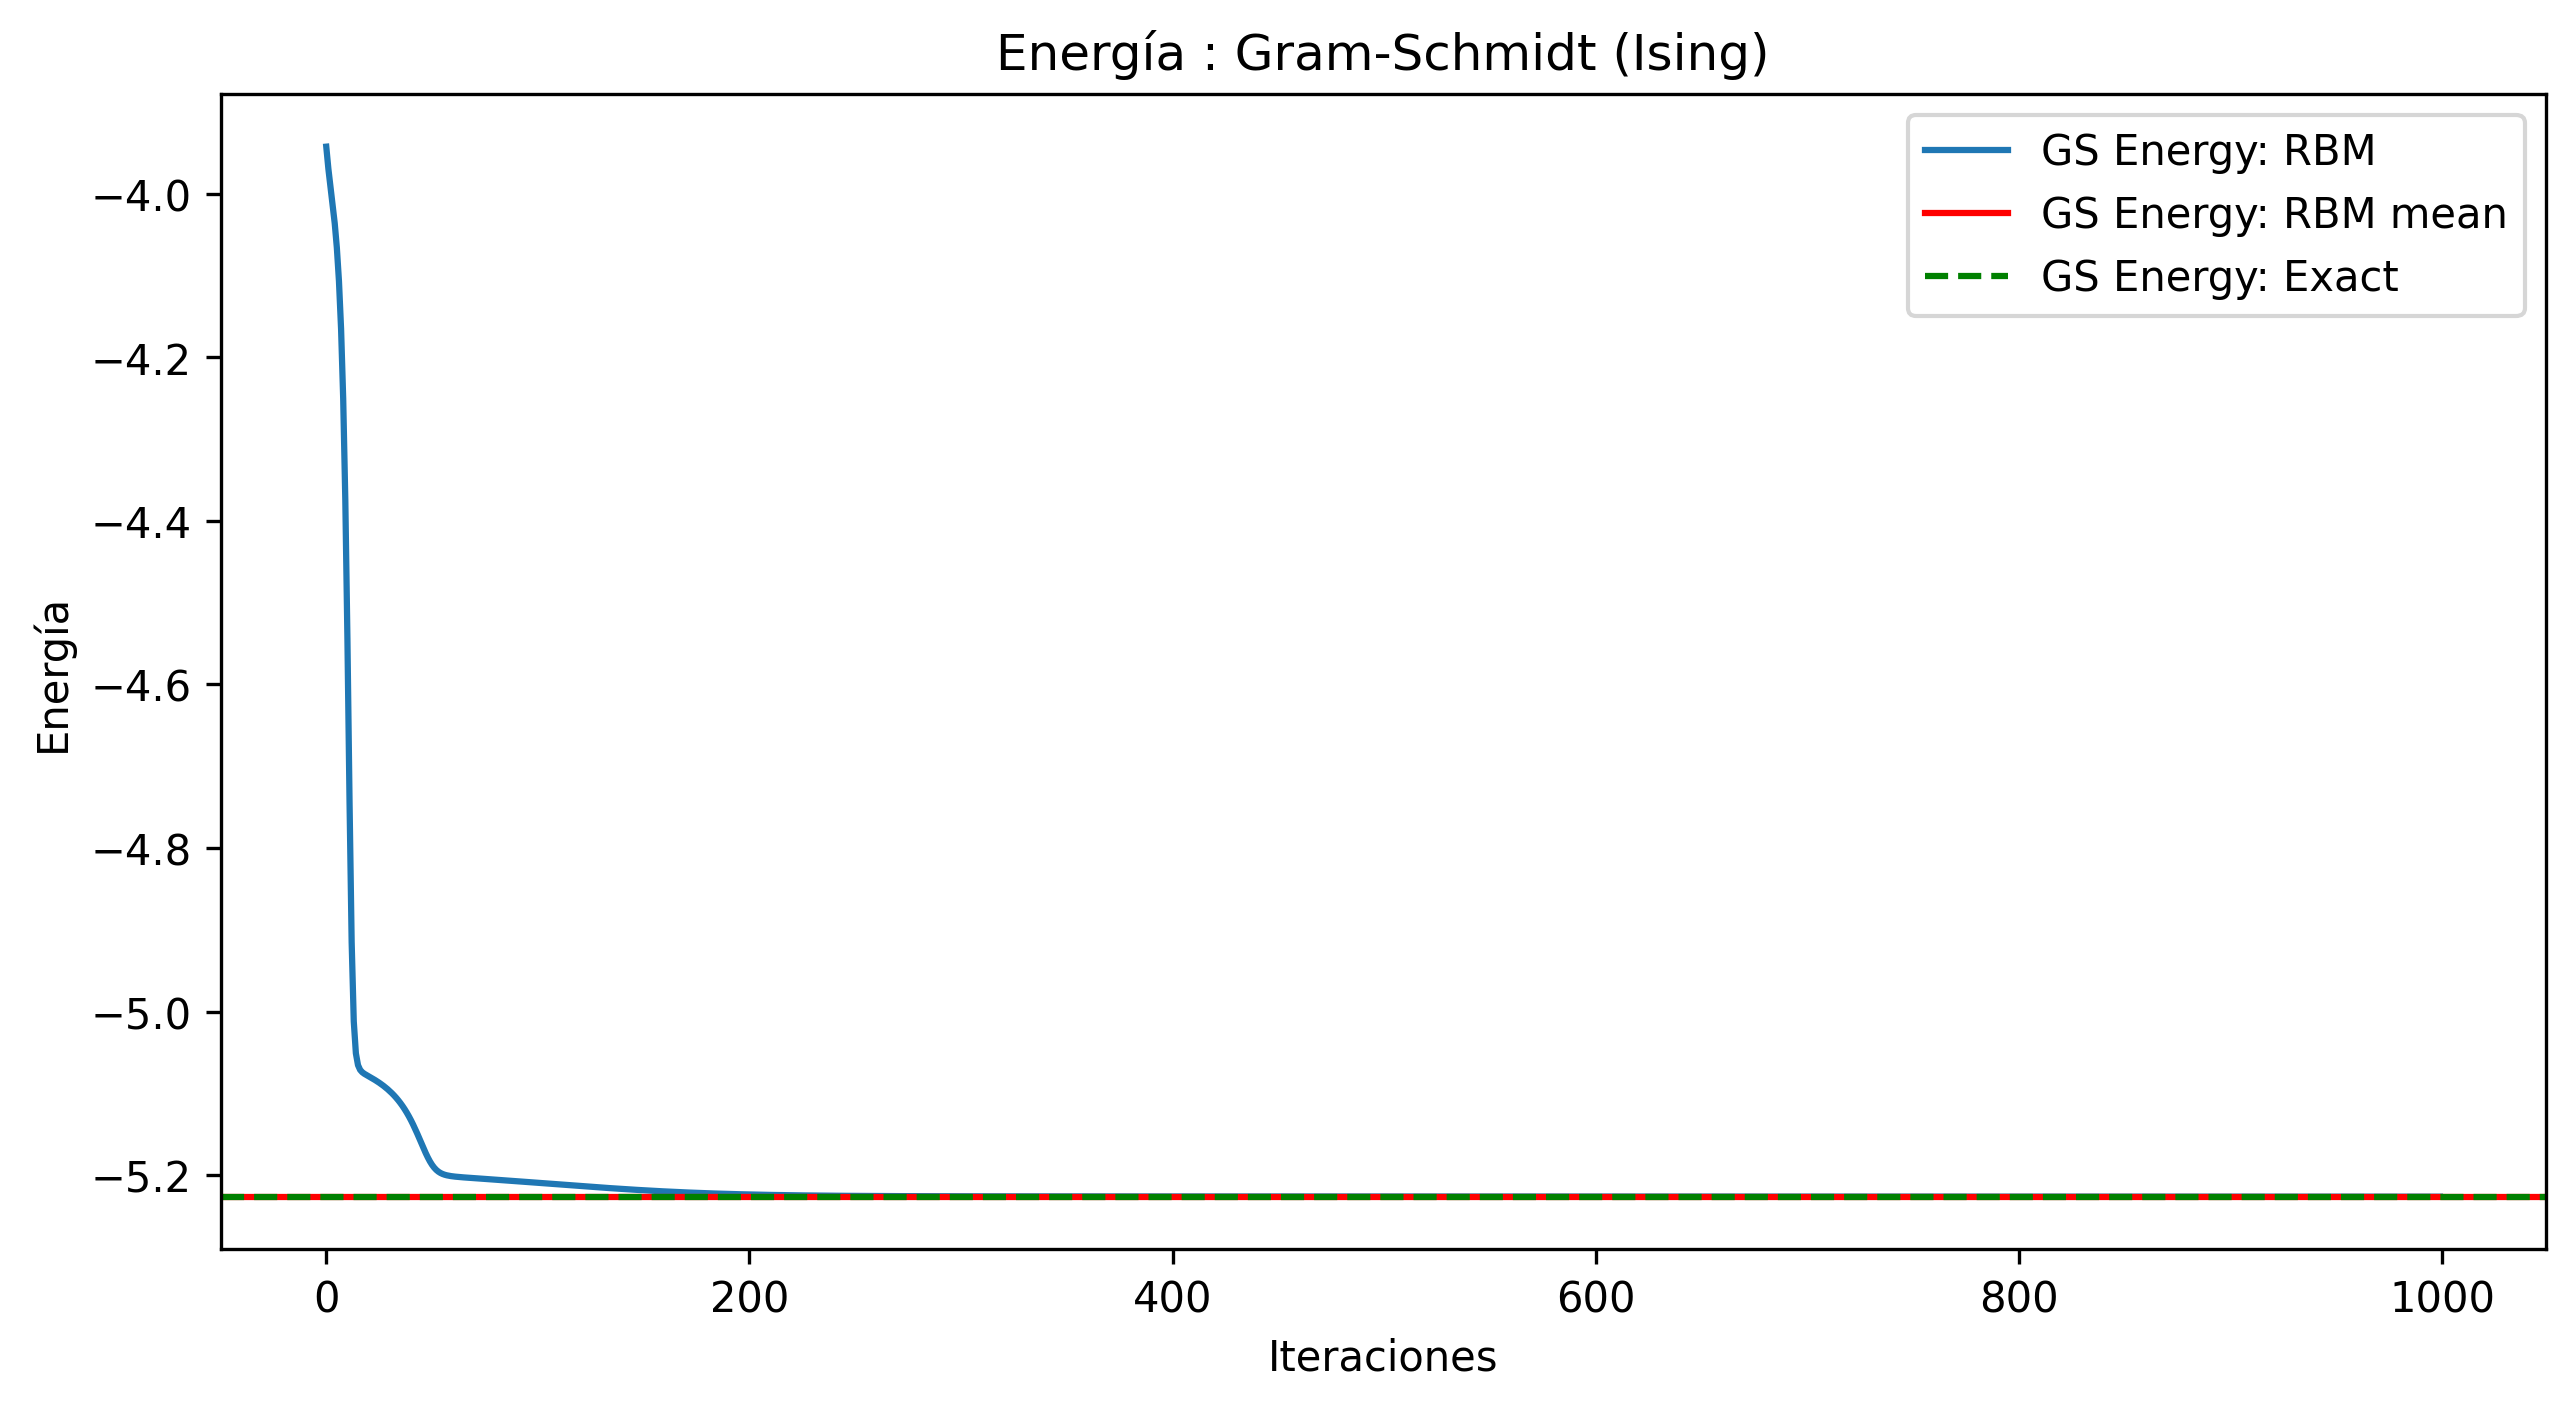

In [78]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 300

plt.title(r"Energía : Gram-Schmidt (Ising)")
plt.xlabel("Iteraciones")
plt.ylabel("Energía")
plt.plot(jnp.array(energies_g), zorder = 2, label = "GS Energy: RBM")
plt.axhline(y = np.mean(jnp.array(energies_g)[n_iters - 50:n_iters], axis = 0), color = 'r', label = "GS Energy: RBM mean")
plt.axhline(y = E_gs, color = 'g', linestyle = 'dashed', label = "GS Energy: Exact")
plt.legend()
#plt.ylim([-13,-11])
#plt.savefig("data_gram/gram_lr_{}.png".format(lr), dpi=300)
plt.show()

In [79]:
@partial(jax.vmap, in_axes = (None, None, 0), out_axes = 0)
@jax.jit
def overlap_x1_g(params_x1, params_g, state):
    return wf_g(params_g, state)*prob_rbm(params_x1, state)

@jax.jit
def wf_x1_d(params_x1, params_g, ovs_g_x1, v_):
    return wf_g(params_x1, v_) - (ovs_g_x1)*wf_g(params_g, v_)

wf_x1_d_batched = jax.vmap(wf_x1_d, in_axes = (None, None, None, 0))

@jax.jit
def wf_x1(params, v_):
    params_x1, params_g, overlap_g_x1 = params
    return wf_x1_d(params_x1, params_g, overlap_g_x1, v_)

@jax.jit
def wf_x1_squared(params, v_):
    return wf_x1(params, v_)**2

wf_x1_batched = jax.vmap(wf_x1, in_axes = (None, 0))

wf_x1_squared_batched = jax.vmap(wf_x1_squared, in_axes = (None, 0))

def norm_x1(params, states):
    return jnp.sum(wf_x1_squared_batched(params, states))

@jax.jit
def log_wf_x1_d(params_x1, params_g, overlap_g_x1, v_):
    return jnp.log(wf_x1_d(params_x1, params_g, overlap_g_x1, v_))

@jax.jit
def log_wf_x1(params, v_):
    params_x1, params_g, overlap_g_x1 = params
    return log_wf_x1_d(params_x1, params_g, overlap_g_x1, v_)

@jax.jit
def log_pdf_x1(params, v_):
    return jnp.log((wf_x1(params, v_))**2)

@jax.jit
def log_grads_x1(params, v_):
    params_x1, params_g, overlap_g_x1 = params
    return jax.grad(log_wf_x1_d)(params_x1, params_g, overlap_g_x1, v_)

In [80]:
'''
params_x1 = params_x1, params_g, norm_g, overlap_g_x1
'''

@partial(jax.vmap, in_axes = (None, None, 0, None), out_axes = 0)
def en_loc_x1(params, prop, pos, n_sites):
    J, g = prop
    func = partial(wf_x1, params)
    local = jnp.sum(pos*jnp.roll(pos, 1))*(-J) + \
                jnp.sum(jnp.array([func(pos.at[i].multiply(-1)) for i in range(n_sites)]))*(-g)/func(pos)
    return local

In [81]:
'''
params = params_x1, params_g, norm_g, overlap_g_x1
'''

#@jax.jit
@partial(jax.vmap, in_axes = (None, 0, 0, None, None), out_axes = 0)
def grad_en_x1(params, sample, loc_en, sv_en, normx1):
    params_x1, params_g, overlap_g_x1 = params
    grads = jax.grad(log_wf_x1_d)(params_x1, params_g, overlap_g_x1, sample)
    prob = wf_x1_squared(params, sample)/normx1
    #return [2*jnp.real(((loc_en - sv_en))*grad) for grad in grads]
    return jax.tree_map(lambda grad: 2*jnp.real(((loc_en - sv_en))*grad*prob), grads)

In [82]:
def sgd_x1(rng_key, params, samples_array, lr, prop, n_sites, normg):
    params_x1, params_g = params 
    ovs_x1_g = sum(overlap_x1_g(params_x1, params_g, samples_array))/normg
    params_for_x1 = (params_x1, params_g, ovs_x1_g)
    normx1 = norm_x1(params_for_x1, samples_array)
    loc_en = en_loc_x1(params_for_x1, prop, samples_array, n_sites)
    sv_en = jnp.sum(loc_en*(wf_x1_batched(params_for_x1, samples_array)**2))/normx1
    grads = grad_en_x1(params_for_x1, samples_array, loc_en, sv_en, normx1)
    grads = jax.tree_util.tree_map(lambda g: jnp.sum(g, axis=0), grads)
    new_params = jax.tree_util.tree_map(lambda p, g: p - lr * g, params_x1, grads)
    return rng_key, sv_en, samples_array, new_params, ovs_x1_g

In [83]:
n_iters =1_000
n_samples = 5_000
n_ter = int(0.5*n_samples)
J = 1.0
g = 1.0
prop = (J, g)
lr = 0.05
n_sites = 4
layer_widths = [n_sites, 64, 32]
alpha_rbm = 3
stdv = 0.01
rng_key = jax.random.PRNGKey(np.random.choice(list(range(10_000))))
params_x1 = init_rbm_params(n_sites)
#params_x1 = jax.tree_util.tree_map(lambda x: x, params_g)
energies_x1 = []
ovps_x1_g = []
normg = norm_g(params_g, states)
for i in range(n_iters):
    rng_key, energy_step_x1, samples_x1, params_x1, ovs = sgd_x1(rng_key, (params_x1, params_g), states, lr, prop, n_sites, normg)
    energies_x1.append(energy_step_x1)
    ovps_x1_g.append(ovs)
    if not i%50:
        print("Voy en el paso {} de {} y la energía es x1={}.".format(i, n_iters, float(energy_step_x1)))


/var/folders/ns/x0vvs1s15bb4wkzknj03y9k40000gn/T/ipykernel_41834/1148067674.py:12: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(lambda grad: 2*jnp.real(((loc_en - sv_en))*grad*prob), grads)


Voy en el paso 0 de 1000 y la energía es x1=-1.5946755486669244.
Voy en el paso 50 de 1000 y la energía es x1=-4.791305607964839.
Voy en el paso 100 de 1000 y la energía es x1=-4.799581903727435.
Voy en el paso 150 de 1000 y la energía es x1=-4.810949274386631.
Voy en el paso 200 de 1000 y la energía es x1=-4.822996109602872.
Voy en el paso 250 de 1000 y la energía es x1=-4.8274262920364865.
Voy en el paso 300 de 1000 y la energía es x1=-4.828271441857476.
Voy en el paso 350 de 1000 y la energía es x1=-4.828389024551672.
Voy en el paso 400 de 1000 y la energía es x1=-4.828404520648534.
Voy en el paso 450 de 1000 y la energía es x1=-4.828407081251329.
Voy en el paso 500 de 1000 y la energía es x1=-4.828407818238673.
Voy en el paso 550 de 1000 y la energía es x1=-4.8284082213637785.
Voy en el paso 600 de 1000 y la energía es x1=-4.8284085376985395.
Voy en el paso 650 de 1000 y la energía es x1=-4.828408819832141.
Voy en el paso 700 de 1000 y la energía es x1=-4.828409081472843.
Voy en el

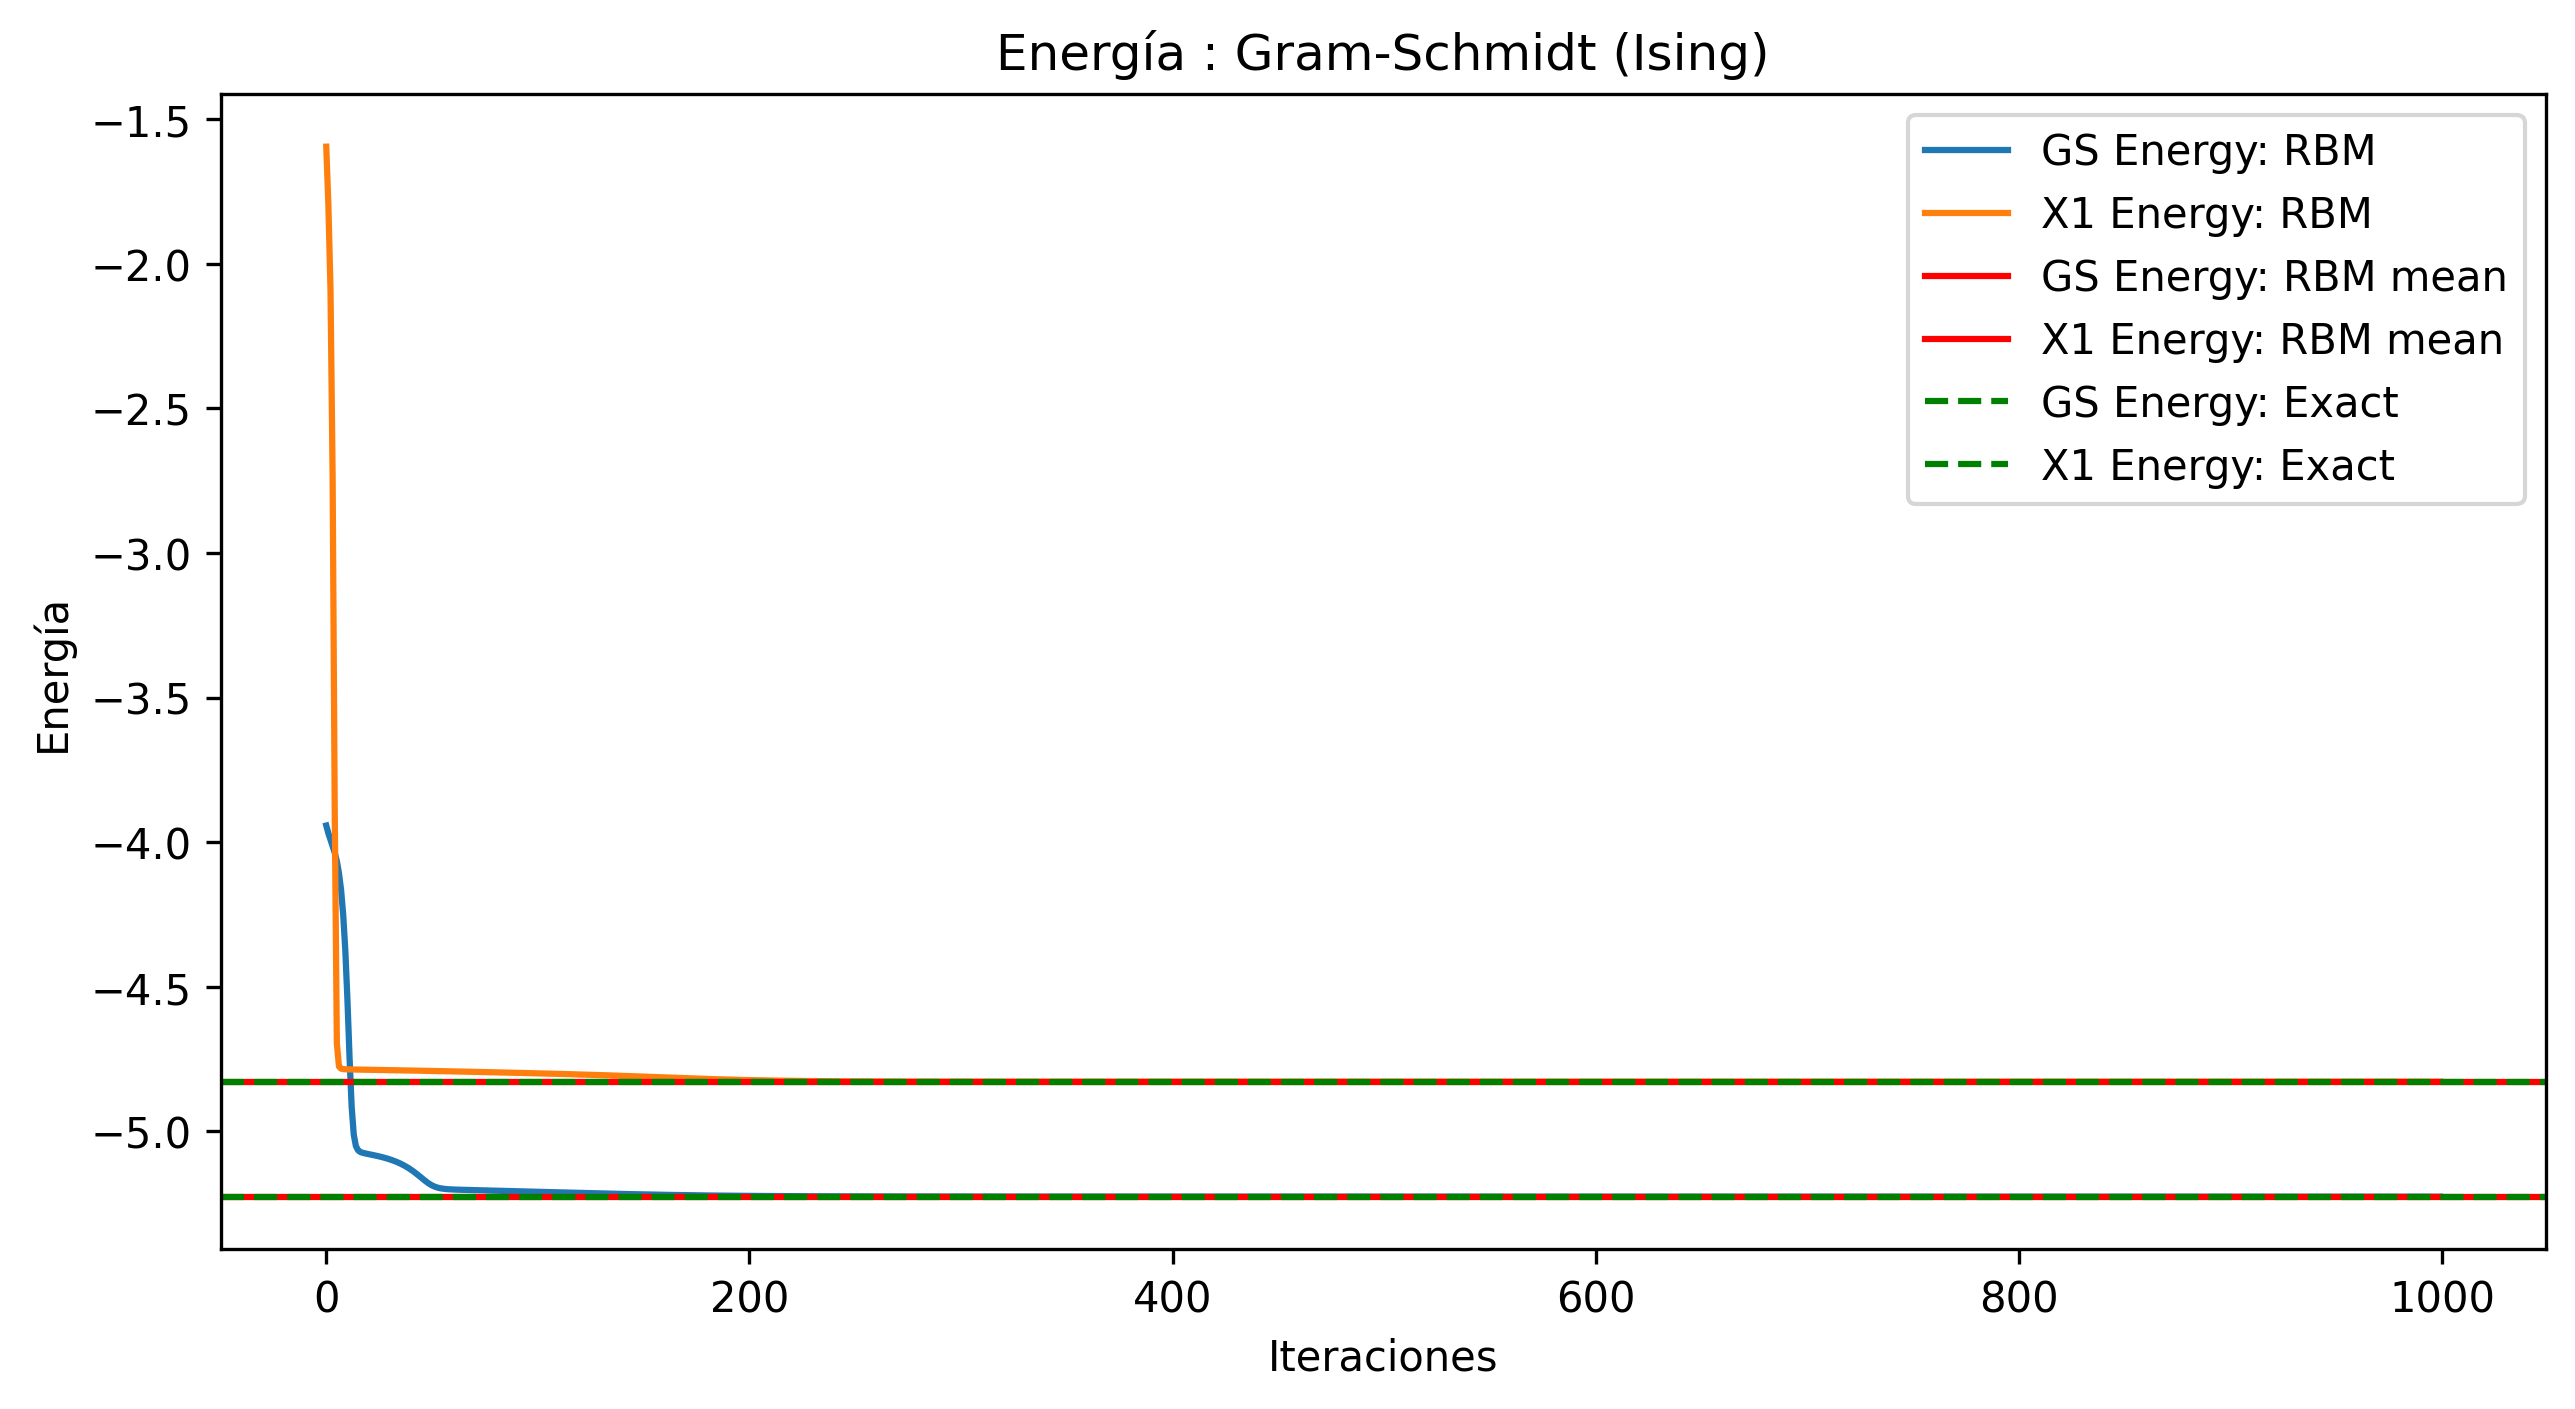

In [84]:
plt.title(r"Energía : Gram-Schmidt (Ising)")
plt.xlabel("Iteraciones")
plt.ylabel("Energía")
plt.plot(jnp.array(energies_g), zorder = 2, label = "GS Energy: RBM")
plt.plot(jnp.array(energies_x1), zorder = 2, label = "X1 Energy: RBM")
plt.axhline(y = np.mean(jnp.array(energies_g)[n_iters - 50:n_iters], axis = 0), color = 'r', label = "GS Energy: RBM mean")
plt.axhline(y = np.mean(jnp.array(energies_x1)[n_iters - 50:n_iters], axis = 0), color = 'r', label = "X1 Energy: RBM mean")
plt.axhline(y = E_gs, color = 'g', linestyle = 'dashed', label = "GS Energy: Exact")
plt.axhline(y = E_x1, color = 'g', linestyle = 'dashed', label = "X1 Energy: Exact")
plt.legend()
#plt.ylim([-13,-11])
#plt.savefig("data_gram/gram_lr_{}.png".format(lr), dpi=300)
plt.show()

In [89]:
@partial(jax.vmap, in_axes = (None, None, None, None, 0), out_axes = 0)
@jax.jit
def overlap_x2_x1(params_x2, params_x1, params_g, ov_x1_g, state):
    return wf_x1_d(params_x1, params_g, ov_x1_g, state)*prob_rbm(params_x2, state)

@partial(jax.vmap, in_axes = (None, None, 0), out_axes = 0)
@jax.jit
def overlap_x2_g(params_x2, params_g, state):
    return wf_g(params_g, state)*prob_rbm(params_x2, state)

@partial(jax.vmap, in_axes = (None, None, None, None, None, None, 0), out_axes = 0)
@jax.jit
def wf_x2_dd(params_x2, params_x1, params_g, ovs_x2_x1, ovs_x2_g, ovs_x1_g, v_):
    return (prob_rbm(params_x2, v_) - (ovs_x2_g)*wf_g(params_g, v_) - (ovs_x2_x1)*wf_x1_d(params_x1, params_g, ovs_x1_g, v_))**2

@jax.jit
def wf_x2_d(params_x2, params_x1, params_g, ovs_x2_x1, ovs_x2_g, ovs_x1_g, norm_rbm_x2, v_):
    coso = prob_rbm(params_x2, v_) - (ovs_x2_g)*wf_g(params_g, v_) - (ovs_x2_x1)*wf_x1_d(params_x1, params_g, ovs_x1_g, v_)
    return coso/norm_rbm_x2

@jax.jit
def wf_x2(params, v_):
    params_x2, params_x1, params_g, ovs_x2_x1, ovs_x2_g, ovs_x1_g, norm_rbm_x2 = params
    return wf_x2_d(params_x2, params_x1, params_g, ovs_x2_x1, ovs_x2_g, ovs_x1_g, norm_rbm_x2, v_)

wf_x2_batched = jax.vmap(wf_x2, in_axes = (None, 0))

@jax.jit
def wf_x2_squared(params, v_):
    return wf_x2(params, v_)**2

wf_x2_squared_batched = jax.vmap(wf_x2_squared, in_axes = (None, 0))

def norm_x2(params, states):
    return jnp.sum(wf_x2_squared_batched(params, states))

@jax.jit
def log_wf_x2_d(params_x2, params_x1, params_g, ovs_x2_x1, ovs_x2_g, ovs_x1_g, norm_rbm_x2, v_):
    return jnp.log(wf_x2_d(params_x2, params_x1, params_g, ovs_x2_x1, ovs_x2_g, ovs_x1_g, norm_rbm_x2, v_))

@jax.jit
def log_wf_x2(params, v_):
    params_x2, params_x1, params_g, ovs_x2_x1, ovs_x2_g, ovs_x1_g, norm_rbm_x2 = params
    return log_wf_x2_d(params_x2, params_x1, params_g, ovs_x2_x1, ovs_x2_g, ovs_x1_g, norm_rbm_x2, v_)

@jax.jit
def log_pdf_x2(params, v_):
    return jnp.log((wf_x2(params, v_))**2)

@jax.jit
def log_grads_x2(params, v_):
    params_x2, params_x1, params_g, ovs_x2_x1, ovs_x2_g, ovs_x1_g, norm_rbm_x2 = params
    return jax.grad(log_wf_x2_d)(params_x2, params_x1, params_g, ovs_x2_x1, ovs_x2_g, ovs_x1_g, norm_rbm_x2, v_)

In [90]:
'''
params_x1 = params_x1, params_g, norm_g, overlap_g_x1
'''

@partial(jax.vmap, in_axes = (None, None, 0, None), out_axes = 0)
def en_loc_x2(params, prop, pos, n_sites):
    J, g = prop
    func = partial(wf_x2, params)
    local = jnp.sum(pos*jnp.roll(pos, 1))*(-J) + \
                jnp.sum(jnp.array([func(pos.at[i].multiply(-1)) for i in range(n_sites)]))*(-g)/func(pos)
    return local

In [91]:
'''
params = params_x1, params_g, norm_g, overlap_g_x1
'''

#@jax.jit
@partial(jax.vmap, in_axes = (None, 0, 0, None), out_axes = 0)
def grad_en_x2(params, sample, loc_en, sv_en):
    # params_x2, params_x1, params_g, ovs_x2_x1, ovs_x2_g, ovs_x1_g = params
    # grads = jax.grad(log_wf_x2_d)(params_x2, params_x1, params_g, ovs_x2_x1, ovs_x2_g, ovs_x1_g, sample)
    grads = log_grads_x2(params, sample)
    prob = wf_x2_squared(params, sample)
    #return [2*jnp.real(((loc_en - sv_en))*grad) for grad in grads]
    return jax.tree_map(lambda grad: 2*jnp.real(((loc_en - sv_en))*grad*prob), grads)

In [92]:
# params_x2, params_x1, params_g, ovs_x2_x1, ovs_x2_g, ovs_x1_g, v_

def sgd_x2(rng_key, params, lr, prop, n_sites, ovs_x1_g, normx1, normg, samples_array):
    params_x2, params_x1, params_g = params
    ovs_x2_g = jnp.sum(overlap_x2_g(params_x2, params_g, samples_array))/normg
    ovs_x2_x1 = jnp.sum(overlap_x2_x1(params_x2, params_x1, params_g, ovs_x1_g, samples_array))/normx1
    norm_rbm_x2 = jnp.sqrt(jnp.sum(wf_x2_dd(params_x2, params_x1, params_g, ovs_x2_x1, ovs_x2_g, ovs_x1_g, samples_array)))
    params_for_x2 = (params_x2, params_x1, params_g, ovs_x2_x1, ovs_x2_g, ovs_x1_g, norm_rbm_x2)
    normx2 = norm_x2(params_for_x2, samples_array)
    loc_en = en_loc_x2(params_for_x2, prop, samples_array, n_sites)
    sv_en = jnp.sum(loc_en*(wf_x2_squared_batched(params_for_x2, samples_array)))/normx2
    grads = grad_en_x2(params_for_x2, samples_array, loc_en, sv_en)
    grads = jax.tree_util.tree_map(lambda g: jnp.sum(g, axis=0), grads)
    new_params = jax.tree_util.tree_map(lambda p, g: p - lr * g, params_x2, grads)
    return rng_key, sv_en, new_params

In [93]:
n_iters =1_000
n_samples = 5_000
n_ter = int(0.5*n_samples)
J = 1.0
g = 1.0
prop = (J, g)
lr = 0.05
n_sites = 4
alpha_rbm = 3
stdv = 0.1

params_x2 = init_rbm_params(n_sites)
rng_key = jax.random.PRNGKey(np.random.choice(list(range(10_000))))
energies_x2 = []
normg = norm_g(params_g, states)
ovs_x1_g = jnp.sum(overlap_x1_g(params_x1, params_g, states))/normg
normx1 = norm_x1((params_x1, params_g, ovs_x1_g), states)
for i in range(n_iters):
    rng_key, energy_step_x2, params_x2 = sgd_x2(rng_key, (params_x2, params_x1, params_g), lr, prop, n_sites, ovs_x1_g, normx1, normg, states)
    energies_x2.append(energy_step_x2)
    if not i%50:
        print("Voy en el paso {} de {} y la energía es x2={}.".format(i, n_iters, float(energy_step_x2)))

/var/folders/ns/x0vvs1s15bb4wkzknj03y9k40000gn/T/ipykernel_41834/3275284426.py:13: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(lambda grad: 2*jnp.real(((loc_en - sv_en))*grad*prob), grads)


Voy en el paso 0 de 1000 y la energía es x2=-1.47303015752692.
Voy en el paso 50 de 1000 y la energía es x2=-2.131012043903497.
Voy en el paso 100 de 1000 y la energía es x2=-2.15987893190071.
Voy en el paso 150 de 1000 y la energía es x2=-2.164460348967667.
Voy en el paso 200 de 1000 y la energía es x2=-2.16465004302826.
Voy en el paso 250 de 1000 y la energía es x2=-2.1646701545867537.
Voy en el paso 300 de 1000 y la energía es x2=-2.1646787528914437.
Voy en el paso 350 de 1000 y la energía es x2=-2.1646853491570712.
Voy en el paso 400 de 1000 y la energía es x2=-2.1646909910987433.
Voy en el paso 450 de 1000 y la energía es x2=-2.164695920112073.
Voy en el paso 500 de 1000 y la energía es x2=-2.164700269357895.
Voy en el paso 550 de 1000 y la energía es x2=-2.164704138791195.
Voy en el paso 600 de 1000 y la energía es x2=-2.1647076076618927.
Voy en el paso 650 de 1000 y la energía es x2=-2.1647107395979392.
Voy en el paso 700 de 1000 y la energía es x2=-2.164713586023294.
Voy en el 

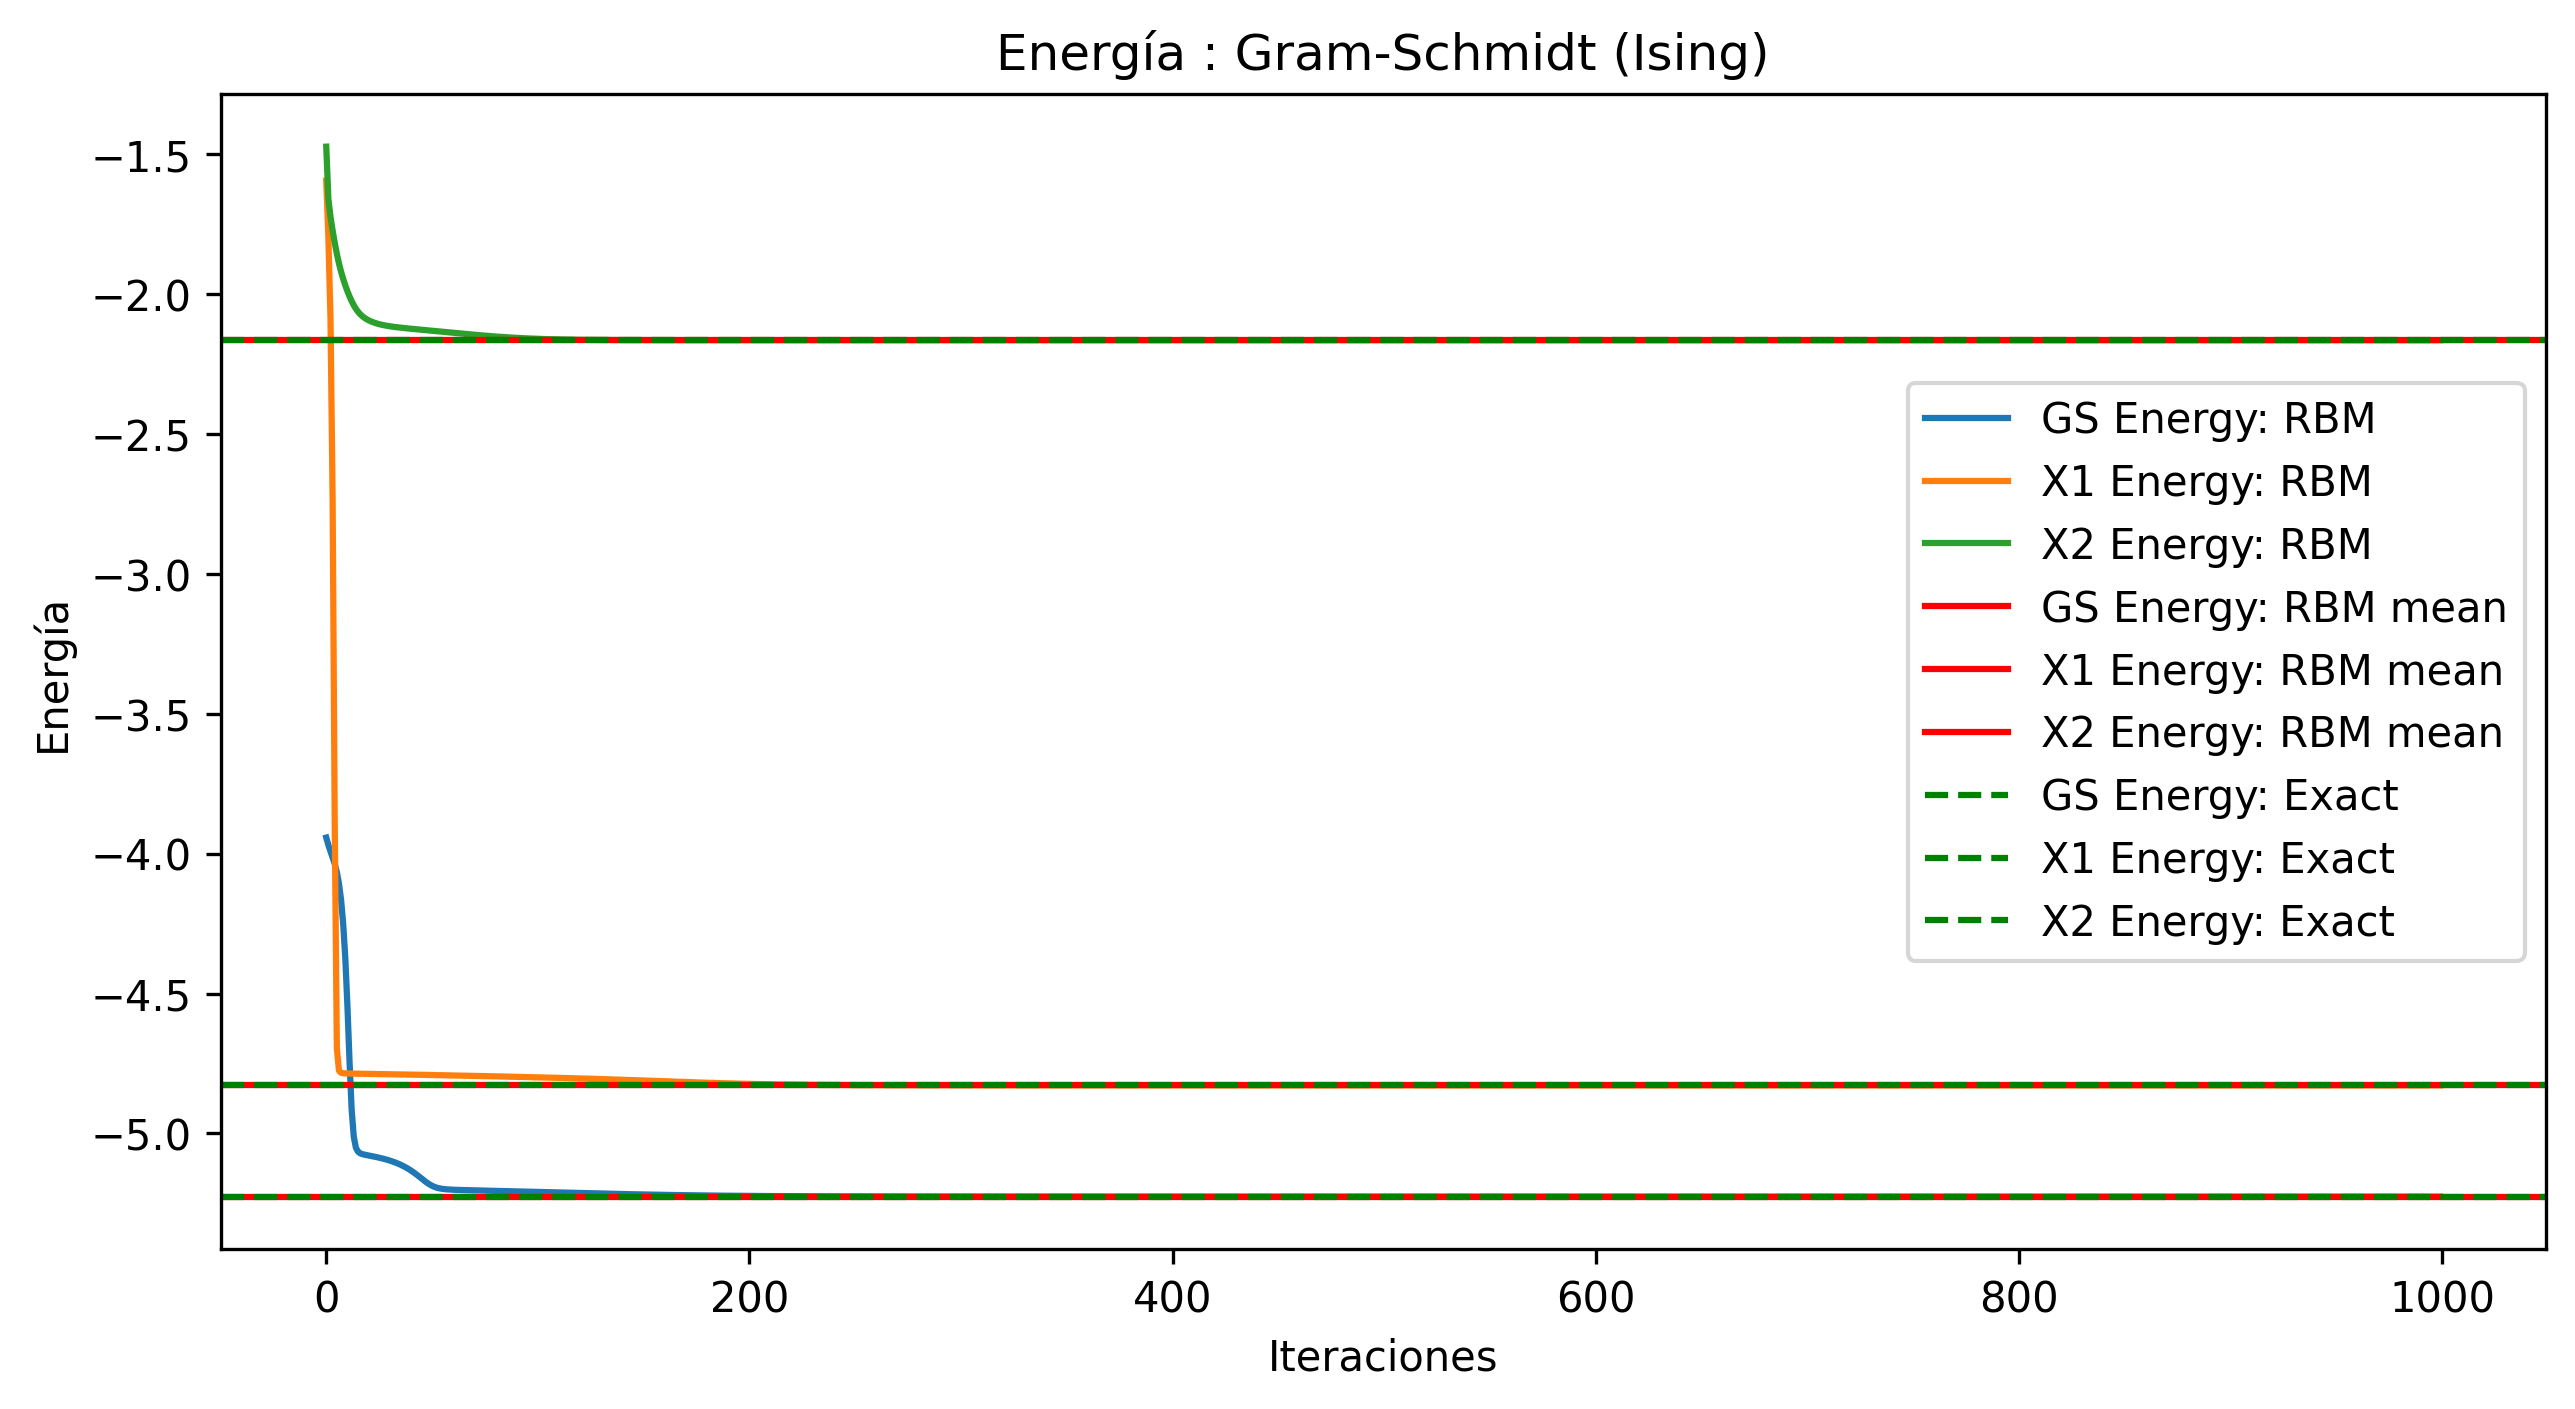

In [94]:
plt.title(r"Energía : Gram-Schmidt (Ising)")
plt.xlabel("Iteraciones")
plt.ylabel("Energía")
plt.plot(jnp.array(energies_g), zorder = 2, label = "GS Energy: RBM")
plt.plot(jnp.array(energies_x1), zorder = 2, label = "X1 Energy: RBM")
plt.plot(jnp.array(energies_x2), zorder = 2, label = "X2 Energy: RBM")
plt.axhline(y = np.mean(jnp.array(energies_g)[n_iters - 50:n_iters], axis = 0), color = 'r', label = "GS Energy: RBM mean")
plt.axhline(y = np.mean(jnp.array(energies_x1)[n_iters - 50:n_iters], axis = 0), color = 'r', label = "X1 Energy: RBM mean")
plt.axhline(y = np.mean(jnp.array(energies_x2)[n_iters - 50:n_iters], axis = 0), color = 'r', label = "X2 Energy: RBM mean")
plt.axhline(y = E_gs, color = 'g', linestyle = 'dashed', label = "GS Energy: Exact")
plt.axhline(y = E_x1, color = 'g', linestyle = 'dashed', label = "X1 Energy: Exact")
plt.axhline(y = E_x2, color = 'g', linestyle = 'dashed', label = "X2 Energy: Exact")
plt.legend()
#plt.ylim([-13,-11])
#plt.savefig("data_gram/gram_lr_{}.png".format(lr), dpi=300)
plt.show()